In [1]:
from lark import Lark, Token, Transformer, Tree
from typing import Dict, Tuple, Sequence, List
from typing import NewType
from pprint import pprint
import re


Token = Dict[str, str]
Block = Dict[str, List[Token]]


def token(_type: str, value: str) -> Token:
    """Returns a token with <_type> and <value>"""
    
    return {
        'value': value,
        'type': _type,
    }


def block(content: List[Token], indent=0) -> Block:
    """
    Returns a block with <_id> and <content>
    <content> is a list of tokens
    """
    
    return {
        'id': hex(hash(str(content)))[2:],
        'content': content,
        'indent': indent
    }


c = [token('TXT', 'hello'), token('REF', 'world')]
pprint(block('0', c))

{'content': '0',
 'id': '354cdab9e8fe2680',
 'indent': [{'type': 'TXT', 'value': 'hello'},
            {'type': 'REF', 'value': 'world'}]}


In [2]:
text = '''
- Earth
    - is nice
    - also called the [[World]]
    - home to [[Human]]s
- [[Max]]
    - is - a [[Human]]
    - likes [[Programming]]
- [[Alien]]
  - comes from jupiter
- [[John]]
    - is a [[Alien]]
        - which is pretty cool in my opinion
        - he's from [[Jupiter]]
            - or one of its moons
        - he calls himself "ˆÒØØ"
    - likes [[Programming]]
    -
- [[Alien]]
  - takes you to a leader, [[John]]
- [[Max]] is not an [[Alien]]
    - and he is not a computer
'''
lines = re.split(r'(\s*\-.*\n)', text)

def extract_tokens(line_text):
    words = re.split(r'\s+', line_text)
    references = re.findall(r'(\[\[[^\[|\]]+\]\])+', line_text)
    tokens = []
    for word in words:
        if word in references:
            tokens.append(token('REF', word))
        else:
            tokens.append(token('TXT', word))
    return tokens

explicit_blocks = []

for line in lines:
    line = line.replace('\n', '')
    if line:
        line_text = re.sub(r'(^\s*\-\s*)', '', line)
        if len(line_text.strip()) > 0:
            indent = len(line) - len(line.lstrip())
            explicit_blocks.append(block(
                content=extract_tokens(line_text),
                indent=indent
            ))


In [3]:
def filter_blocks(blocks, pred):
    results = []
    for blk in blocks:
        if pred(blk):
            results.append(blk)
    return results

def find_by_token_value(token_value, blocks):
    return filter_blocks(
        blocks,
        lambda b: token_value in [x['value'] for x in b['content']]
    )

def find_by_token_type(token_type, blocks):
    return filter_blocks(
        blocks,
        lambda b: token_type in [x['type'] for x in b['content']]
    )
    
id_to_block = {}
for blk in explicit_blocks:
    id_to_block[blk['id']] = blk


In [4]:
def resolve_parent(child, blocks):
    if child not in blocks:
        return None
    child_index = blocks.index(child)
    prev_blocks = blocks[:child_index]
    for blk in prev_blocks[::-1]:
        if blk['indent'] < child['indent']:
            return blk
    return None

In [5]:
def resolve_immediate_children(parent, blocks):
    if parent not in blocks:
        return []
    return filter_blocks(
        blocks[blocks.index(parent) + 1:],
        lambda b: resolve_parent(b, blocks) == parent
    )


In [6]:
def get_roots(blocks):
    roots = []
    for blk in blocks:
        if resolve_parent(blk, blocks) is None:
            roots.append(blk)
    return roots

In [7]:

def resolve_trees(roots, blocks, successorFunc=resolve_immediate_children, checked=set()):
    trees = []
    for root in roots:
        print(root['id'], root['id'] not in checked)
        if root['id'] not in checked:
            checked.add(root['id'])
            trees.append({
                'children': resolve_trees(
                    successorFunc(root, blocks),
                    blocks,
                    successorFunc,
                    checked=checked
                ),
                'data': root
            })
    return trees

trees = resolve_trees(
    get_roots(explicit_blocks),
    explicit_blocks,
    resolve_immediate_children,
    set([])
)

x55921ef8dac3679f True
72a06f6d5e31ff3a True
x4e9bc05e711f82d6 True
2a7cd32397905ba2 True
6cea34b47a993bc4 True
26719b072c44f82e True
6a33d92aaf1c2c63 True
6a33d92aaf1c2c63 False
x606fd4741d574407 True
x75d086b67bc3f607 True
86fdb6233504cb6 True
1fc99648388bd624 True
x719e4cfd26f8d31a True
x20cadce4089bd7e4 True
x40403bcbf01bcd3d True
x2628be0a39fe5a0a True
6b024f009eb4ffb2 True
x606fd4741d574407 False
77ba77191c2e0bbb True
x9373a95a88831fc True


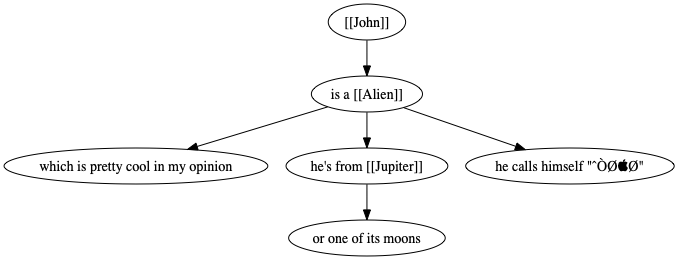

In [8]:
import pydot
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
from IPython.display import Image, display


def tokens_to_str(tokens):
    return ' '.join([x['value'] for x in tokens])

def draw(graph, parent_name, child_name):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)
    

def draw_tree(tree):
    graph = pydot.Dot(graph_type='digraph')
    def helper(tree):
        node_value = tree['data']
        node_content = tokens_to_str(node_value['content'])
        children = tree['children']
        for c in children:
            helper(c)
            draw(graph, node_content, tokens_to_str(c['data']['content']))
    helper(tree)
    graph.write_png('example1_graph.png')
    display(Image('example1_graph.png'))
    os.remove('example1_graph.png')

draw_tree(trees[3])


In [9]:
def resolve_reference(ref_value, blocks):
    for blk in blocks:
        if len(blk['content']) == 1 and blk['content'][0]['type'] == 'REF' and blk['content'][0]['value'] == ref_value:
            return blk
    return block([token('REF', ref_value)], indent=0)

def resolve_block_references(blk, blocks):
    refs = []
    for token in blk['content']:
        if token['type'] == 'REF':
            refs.append(resolve_reference(token['value'], blocks))
    return refs


jupiter = resolve_reference('[[Jupiter]]', explicit_blocks)
resolve_immediate_children(jupiter, explicit_blocks)


[]

In [10]:
from collections import defaultdict

links = {
    'references': resolve_block_references,
    'children': resolve_immediate_children
}
    
def get_links_out(blk, blocks):
    links_out = defaultdict(lambda: [])
    for link_type in links:
        links_out[link_type] += links[link_type](blk, blocks)
    return links_out


def get_links_in(blk, blocks):
    links_in = defaultdict(lambda: [])
    for b in blocks:
        b_out = get_links_out(b, blocks)
        for link_type in b_out:
            if blk in b_out[link_type]:
                links_in[link_type].append(b)
    return links_in

    
    

x = find_by_token_value('[[Jupiter]]', explicit_blocks)[0]
print(x)

get_links_out(x, explicit_blocks)


{'id': 'x40403bcbf01bcd3d', 'content': [{'value': "he's", 'type': 'TXT'}, {'value': 'from', 'type': 'TXT'}, {'value': '[[Jupiter]]', 'type': 'REF'}], 'indent': 8}


defaultdict(<function __main__.get_links_out.<locals>.<lambda>()>,
            {'references': [{'id': 'x1384d2f04523b8a1',
               'content': [{'value': '[[Jupiter]]', 'type': 'REF'}],
               'indent': 0}],
             'children': [{'id': 'x2628be0a39fe5a0a',
               'content': [{'value': 'or', 'type': 'TXT'},
                {'value': 'one', 'type': 'TXT'},
                {'value': 'of', 'type': 'TXT'},
                {'value': 'its', 'type': 'TXT'},
                {'value': 'moons', 'type': 'TXT'}],
               'indent': 12}]})